## Import libraries

In [ ]:
import torch
import torchvision
from torch import nn
import torch.nn.functional as F
import math

from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True


In [ ]:
img_dim  = 320
img_size = 320


In [ ]:
# !pip install -U git+https://github.com/albu/albumentations --no-cache-dir


## Dataloader

In [ ]:
import torch 
import torchvision
from torch.utils.data import Dataset,DataLoader
from torchvision import transforms
from matplotlib import pyplot as plt
from PIL import Image
import glob2
import numpy as np
import albumentations as A 
from albumentations.pytorch import ToTensor
import cv2



In [ ]:
class yolo_image_dataset(Dataset):
    def __init__(self,image_path,label_path, transform_albumentations):
        super().__init__()
        self.image_path = image_path
        self.label_path = label_path
        self.transform_albumentations  = transform_albumentations
        self.imagelist        = glob2.glob(self.image_path+"/*jpg")

    def __getitem__(self,index):
        image_path  = self.imagelist[index]
        image       = Image.open(image_path)
        image_type = image.mode
        
        image_array = np.array(image)
        print("image_path",image_path)
        
        if(image_type != 'RGB'):
            im = image_array
            w, h = im.shape
            image_array = np.empty((w, h, 3), dtype=np.uint8)
            image_array[:, :, 2] =  image_array[:, :, 1] =  image_array[:, :, 0] =  im

        image_filename = image_path.split("/")[-1]      
        image_filename = image_filename.split(".")[0]  

        label_path = self.label_path + "/" + image_filename + ".txt"
        label_file_list = open(label_path,'r').read().splitlines()  
        albumentations_bbox = []  
        category_ids = []
        for line in label_file_list:
            anno = line.split(" ")
            X , Y , W, H, class_id  = float(anno[1]),float(anno[2]),float(anno[3]),float(anno[4]) , int (anno[0])
#             single_box = [ X , Y , W , H, class_id] 
            single_box = [min(X,0.995), min(Y,0.995), min(W,0.995) , min(H,0.995) , class_id]
            albumentations_bbox.append(single_box)
            category_ids.append(class_id )
        
        # transformed_albumentations = self.transform_albumentations(image=image_array, bboxes=albumentations_bbox) # used while training
        transformed_albumentations = self.transform_albumentations(image=image_array, bboxes=albumentations_bbox,category_ids=category_ids)  # Only for visualizing 
        image = transformed_albumentations['image']   
        bbox  = transformed_albumentations['bboxes'] 
        bbox_tensor = torch.tensor(bbox) 
        if len(bbox_tensor) > 0:
            bbox_tensor = torch.index_select(bbox_tensor,1,torch.LongTensor([4,0,1,2,3])) 
        else:
            target = torch.tensor([])
            return image_path , image , target
#             bbox_tensor = torch.zeros(1,5)  
            
        target = torch.zeros(len(bbox),6)
        target[:,1:] = bbox_tensor

        # return  image_path , image , target   # used while training
        return transformed_albumentations        # Only for visualizing 
    
    
    def collate_fn(self,batch):   
        img_paths , imgs , targets = list(zip(*batch)) 
        
        i = 0
        for target in targets: #target for each image
            # target= list of [img_id,class_id,X,Y,W,H] for each bbox in a given image 
            if len(target) > 0:  # No empty target , No tensor([])
                target[:,0] = i  # Update img_id 
            i = i+1
                
        targets = [boxes for boxes in targets if boxes is not None] #Remove empty bbox from target
        target_tensor = torch.cat(targets, 0) 

        imgs = torch.stack([img for img in imgs])

        return img_paths, imgs, target_tensor
    
        
    def __len__(self): 
        total_images = len(self.imagelist)
        return total_images

In [ ]:
# !pip uninstall albumentations
# !pip install -U git+https://github.com/albu/albumentations --no-cache-dir



In [ ]:
transform_albumentations = A.Compose([
    A.SmallestMaxSize(max_size=img_size,interpolation=cv2.INTER_LINEAR) ,
    A.RandomCrop(height=img_size, width=img_size),  
#     A.Normalize(), 
    ToTensor() 
], bbox_params=A.BboxParams(format='yolo', label_fields=['category_ids']) ) 

test_dataset    = yolo_image_dataset(image_path='images/', label_path='labels/',transform_albumentations=transform_albumentations)
test_dataloader = DataLoader(dataset=test_dataset, batch_size=32,num_workers=8 ,collate_fn=test_dataset.collate_fn, shuffle = True)


In [ ]:
BOX_COLOR = (255, 0, 0) # Red
TEXT_COLOR = (255, 255, 255) # White

def visualize_bbox(img, bbox, class_name, img_size=None, color=BOX_COLOR, thickness=2): # img_size need for YOLO format
    """Visualizes a single bounding box on the image"""

    ### --------------------YOLO Format --------------------
    # Image data can be in [0. 1.] or [0. 255.]
    # Bbox value must be [0. 255.]
    x_center, y_center, w ,h = bbox[0]*img_size , bbox[1]*img_size , bbox[2]*img_size, bbox[3]*img_size
    x_min = int(x_center - w / 2)
    y_min = int(y_center - h / 2)
    print("bbox",bbox)
    #------------------------------------------------------

    # x_min, y_min, w, h = bbox  # For COCO Format
    x_min, x_max, y_min, y_max = int(x_min), int(x_min + w), int(y_min), int(y_min + h)
   
    cv2.rectangle(img, (x_min, y_min), (x_max, y_max), color=color, thickness=thickness)
    
    ((text_width, text_height), _) = cv2.getTextSize(class_name, cv2.FONT_HERSHEY_SIMPLEX, 0.35, 1)    
    cv2.rectangle(img, (x_min, y_min - int(1.3 * text_height)), (x_min + text_width, y_min), BOX_COLOR, -1)
    cv2.putText(
        img,
        text=class_name,
        org=(x_min, y_min - int(0.3 * text_height)),
        fontFace=cv2.FONT_HERSHEY_SIMPLEX,
        fontScale=0.35, 
        color=TEXT_COLOR, 
        lineType=cv2.LINE_AA,
    )
    return img


def visualize(image, bboxes, category_ids, category_id_to_name,img_size):
    img = image.copy()
    for bbox, category_id in zip(bboxes, category_ids):
        class_name = category_id_to_name[category_id]
        # print("bbox",bbox)
        img = visualize_bbox(img, bbox, class_name,img_size)

    plt.figure(figsize=(2, 2))
    plt.axis('off')
    plt.imshow(img)
    plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


image_path images/0a451ad29b8506c9.jpg
(320, 320, 3)
bbox (0.434375, 0.521875, 0.7353515625, 0.779296875, 1)


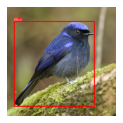

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


image_path images/f3bbe13b005777b3.jpg
(320, 320, 3)
bbox (0.009375, 0.53125, 0.02919921875, 0.17423133235724747, 0)
bbox (0.334375, 0.484375, 0.678125, 0.28111273792093705, 0)
bbox (0.771875, 0.475, 0.4478515625, 0.24890190336749632, 0)


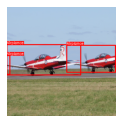

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


image_path images/0de6da38397a8a45.jpg
(320, 320, 3)
bbox (0.36875, 0.509375, 0.7488525390625, 0.4773869346733669, 0)


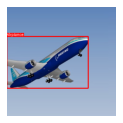

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


image_path images/5efb2436dc047c76.jpg
(320, 320, 3)
bbox (0.503125, 0.259375, 0.70888671875, 0.3072916666666667, 0)
bbox (0.65, 0.721875, 0.6923583984375, 0.28515625, 0)


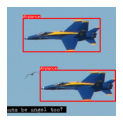

image_path images/20e2d1833a1a9305.jpg
(320, 320, 3)
bbox (0.615625, 0.5625, 0.761297607421875, 0.775, 1)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


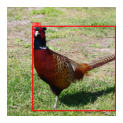

In [ ]:
category_id_to_name = {0: 'Airplance', 1: 'Bird'}

for id in range(5):
  transformed = test_dataset[id]
  image_arr = transformed['image'].permute(1,2,0).numpy()
  print(image_arr.shape)

  visualize(
      image_arr,
      transformed['bboxes'],
      transformed['category_ids'],
      category_id_to_name,
      img_size=img_size
  )